# Final-Project-Jingjing-Li_Smitali-Patnaik

## Introduction

## Supervised Learning Idea and Data Split

In [331]:
# Prepare the environment for Windows operation systems
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Import the modules
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate
from math import *
# Create a new Spark session
spark = SparkSession.builder.getOrCreate()

# Configurate the Spark session
ps.set_option("compute.default_index_type", "distributed")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

In [332]:
# Read in data 
spdf=spark.read.load("C:/Users/smipa/Downloads/ParisHousing.csv",
                     format="csv",sep=",", inferSchema="true", header="true")
spdf.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|    price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|       75523|            3|      0|      1|    63|    9373|            3|            8|2005|         0|                1|    4313| 9005|   956|             0|           7|7559081.5|
|       80771|           39|      1|      1|    98|   39381|            8|            6|2015|         1|                0|    3653| 2436|   128|             1|           2|8085989.5|
|       55712|           58|      0|      1|    19|   34457|            6|           

#### Splitting the priec ecolumn into categories. We have used 3 categories here for the price. 
#### '0' represents "Low Price"
#### '1' represents "Medium Price"
#### '2' represents "High Price"



In [3]:
from pyspark.sql.functions import when
quantiles = spdf.approxQuantile("price", [0.25, 0.5, 0.75], 0)
spdf = spdf.withColumn("cat_price", when(spdf.price <= quantiles[0] ,0) \
      .when((spdf.price > quantiles[0]) & (spdf.price <= quantiles[1] ),1) \
      .otherwise(2))
spdf.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|    price|cat_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+---------+
|       75523|            3|      0|      1|    63|    9373|            3|            8|2005|         0|                1|    4313| 9005|   956|             0|           7|7559081.5|        2|
|       80771|           39|      1|      1|    98|   39381|            8|            6|2015|         1|                0|    3653| 2436|   128|             1|           2|8085989.5|        2|
|       55712|           58|      0

Then, we split data into two parts for train and test respectively.

In [4]:
# Split data
train, test = spdf.randomSplit(weights=[0.8,0.2], seed=200)

In [5]:
train.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|  price|cat_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+
|          89|           33|      0|      0|    72|   61648|            3|            4|1995|         0|                1|    3114| 1258|   264|             1|           9|10313.5|        0|
|         111|           32|      0|      1|    34|   80623|            1|            4|2003|         1|                0|    2239| 2795|   951|             1|           7|14431.3|        0|
|         123|           61|      0|      0| 

In [6]:
# Display initial 5 records
train.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|  price|cat_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+
|          89|           33|      0|      0|    72|   61648|            3|            4|1995|         0|                1|    3114| 1258|   264|             1|           9|10313.5|        0|
|         111|           32|      0|      1|    34|   80623|            1|            4|2003|         1|                0|    2239| 2795|   951|             1|           7|14431.3|        0|
|         123|           61|      0|      0| 

For modeling purpose, we need to remove supervising variable to get predictors. 

In [7]:
# Determine predictor for modeling later
X_train=train.drop('price')
X_train.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|cat_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|          89|           33|      0|      0|    72|   61648|            3|            4|1995|         0|                1|    3114| 1258|   264|             1|           9|        0|
|         111|           32|      0|      1|    34|   80623|            1|            4|2003|         1|                0|    2239| 2795|   951|             1|           7|        0|
|         123|           61|      0|      0|     1|   33633|            9|           

We also need define the supervising variable.

In [270]:
# Determine the reponse variable
y_train=train.select('squareMeters','price')
y_train.show(5)

+------------+-------+
|squareMeters|  price|
+------------+-------+
|          89|10313.5|
|         111|14431.3|
|         123|13229.1|
|         128|15488.0|
|         141|22670.7|
+------------+-------+
only showing top 5 rows



#### This is just for show purpose. As the corr is same, need to delete it in the final version

In [281]:
#### Min Max Scaling of Xtrain
Xcols=['squareMeters','price']
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import SQLTransformer,VectorAssembler,MinMaxScaler
from pyspark.ml import Pipeline
assembler = VectorAssembler(inputCols=Xcols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
pipeline = Pipeline(stages=[assembler, scaler])
scalerModel = pipeline.fit(train)
scaled_train = scalerModel.transform(train)
scaled_train=scaled_train.select('features_scaled')
scaled_train.show()

# Getting all the transfomred featy
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType

def split_array(col):
    def to_list(v):
        return v.toArray().tolist()
    return F.udf(to_list, ArrayType(DoubleType()))(col)

df3 = scaled_train.select(split_array(F.col("features_scaled")).alias("split_int"))\
    .select([F.col("split_int")[i] for i in range(len(Xcols))])
df3.show()

+--------------------+
|     features_scaled|
+--------------------+
|           (2,[],[])|
|[2.20198178360524...|
|[3.40306275648083...|
|[3.90351316184566...|
|[5.20468421579421...|
|[5.40486437794014...|
|[5.90531478330497...|
|[6.00540486437794...|
|[6.30567510759683...|
|[6.40576518866980...|
|[7.40666599939946...|
|[7.40666599939946...|
|[8.70783705334801...|
|[9.10819737763987...|
|[9.80882794515063...|
|[0.00107096386748...|
|[0.00113101791612...|
|[0.00121108998098...|
|[0.00122109898909...|
|[0.00146131518366...|
+--------------------+
only showing top 20 rows

+--------------------+--------------------+
|        split_int[0]|        split_int[1]|
+--------------------+--------------------+
|                 0.0|                 0.0|
|2.201981783605245E-4|4.119259165174079...|
|3.403062756480833E-4|2.916633158963900...|
|3.903513161845661...|5.176333612655612E-4|
|5.204684215794215E-4|0.001236157884207323|
|5.404864377940147E-4|6.759894557449086E-4|
|5.905314783304974E-4|6.48

In [282]:
#scaled output for squareMeters and price
df3=df3.toDF(*Xcols)
df3.show()


+--------------------+--------------------+
|        squareMeters|               price|
+--------------------+--------------------+
|                 0.0|                 0.0|
|2.201981783605245E-4|4.119259165174079...|
|3.403062756480833E-4|2.916633158963900...|
|3.903513161845661...|5.176333612655612E-4|
|5.204684215794215E-4|0.001236157884207323|
|5.404864377940147E-4|6.759894557449086E-4|
|5.905314783304974E-4|6.487998243617838E-4|
| 6.00540486437794E-4|0.001334432696093...|
|6.305675107596837E-4|0.001185089794357...|
|6.405765188669803E-4|0.001219001807010...|
| 7.40666599939946E-4|7.051998029261906E-4|
| 7.40666599939946E-4| 9.47835751858381E-4|
|8.707837053348014E-4|8.674572793920792E-4|
|9.108197377639876E-4|9.327804188077545E-4|
|9.808827945150635E-4|0.001622614778833...|
|0.001070963867480...|0.001350968553590...|
|0.001131017916124...|0.001798847205645656|
|0.001211089980982...|0.001772077723091851|
|0.001221098989090...|0.001375027075841...|
|0.001461315183665...|0.00183494

In [283]:
##correleation b/w scaled data
train_scaled=train.drop('squareMeters','price')
train_scaled=train_scaled.to_pandas_on_spark()
train_1=df3.to_pandas_on_spark()
ps_train_scaled=train_scaled.join(train_1)
ps_train_scaled.corr()


C:\Users\smipa\anaconda3\lib\site-packages\pyspark\sql\dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
C:\Users\smipa\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: MatrixUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,cat_price,squareMeters,price
numberOfRooms,1.000000,-0.002026,0.025064,0.025580,0.008786,0.003964,0.022695,0.006171,0.002984,-0.019973,-0.012659,0.017830,0.020140,-0.007714,-0.028996,0.025584,0.018112,0.018139
hasYard,-0.002026,1.000000,0.022319,0.007221,0.011608,0.000510,0.013940,-0.001031,-0.019186,-0.014477,-0.012269,-0.008550,-0.009474,-0.016018,-0.009306,-0.007448,-0.006920,-0.006379
hasPool,0.025064,0.022319,1.000000,-0.004498,0.002839,0.010935,-0.011100,0.004553,-0.000551,0.008231,-0.004457,-0.010662,0.003959,0.002272,0.010486,0.003308,-0.007275,-0.006744
floors,0.025580,0.007221,-0.004498,1.000000,0.003560,0.003539,0.002120,0.008657,0.011376,-0.009689,0.013451,0.007498,0.013224,0.004201,-0.015645,-0.001498,0.001266,0.001813
cityCode,0.008786,0.011608,0.002839,0.003560,1.000000,0.006340,-0.010801,0.022962,0.002324,0.002648,0.000262,-0.001843,-0.000273,0.002974,-0.000929,-0.007608,0.003348,0.003354
cityPartRange,0.003964,0.000510,0.010935,0.003539,0.006340,1.000000,0.007545,0.001559,-0.000573,0.011112,0.005079,0.010184,0.006154,-0.011989,-0.007684,0.008556,0.009571,0.009624
numPrevOwners,0.022695,0.013940,-0.011100,0.002120,-0.010801,0.007545,1.000000,0.002941,-0.019256,0.003950,0.006442,0.002745,0.023401,0.031660,-0.004088,0.022560,0.021107,0.021112
made,0.006171,-0.001031,0.004553,0.008657,0.022962,0.001559,0.002941,1.000000,-0.005893,-0.005240,-0.008512,0.007095,0.014569,-0.008558,-0.010441,-0.009393,-0.011790,-0.011787
isNewBuilt,0.002984,-0.019186,-0.000551,0.011376,0.002324,-0.000573,-0.019256,-0.005893,1.000000,-0.000760,-0.012884,0.023872,-0.001470,0.002765,0.026291,-0.016416,-0.017515,-0.017491
hasStormProtector,-0.019973,-0.014477,0.008231,-0.009689,0.002648,0.011112,0.003950,-0.005240,-0.000760,1.000000,-0.004230,-0.005765,0.004419,-0.007491,-0.007824,0.006699,0.013962,0.013979


## EDA

#### First, we are interested in seeing if there is relationshipes between the Predictors and the predicted avairable. This starts with quantifying the correlation between the variables.Here the spark dataframe is converted to pandas on spark dataframe and the data is studies using plots and tables. 

In [12]:
train_ps=train.to_pandas_on_spark()

C:\Users\smipa\anaconda3\lib\site-packages\pyspark\sql\dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cat_price
0,89,33,0,0,72,61648,3,4,1995,0,1,3114,1258,264,1,9,10313.5,0
1,111,32,0,1,34,80623,1,4,2003,1,0,2239,2795,951,1,7,14431.3,0
2,123,61,0,0,1,33633,9,1,2011,0,1,9390,6219,922,0,9,13229.1,0
3,128,38,0,1,6,8862,6,2,1990,0,0,6861,5769,442,0,5,15488.0,0
4,141,16,0,1,58,42248,5,4,1997,1,0,3411,8985,213,0,4,22670.7,0


#### Correlation table states that only squareMeters has the strongest linear relationship with price variable. Other variables do not show any significant relationship. As we see there are also many discrete variablles in the data. The relationship may not be strong with a simple correlation step.

In [13]:
train_ps.corr()

C:\Users\smipa\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: MatrixUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cat_price
squareMeters,1.000000,0.018112,-0.006920,-0.007275,0.001266,0.003348,0.009571,0.021107,-0.011790,-0.017515,0.013962,-0.003347,0.000494,-0.021376,0.000758,-0.005259,0.999999,0.913687
numberOfRooms,0.018112,1.000000,-0.002026,0.025064,0.025580,0.008786,0.003964,0.022695,0.006171,0.002984,-0.019973,-0.012659,0.017830,0.020140,-0.007714,-0.028996,0.018139,0.025584
hasYard,-0.006920,-0.002026,1.000000,0.022319,0.007221,0.011608,0.000510,0.013940,-0.001031,-0.019186,-0.014477,-0.012269,-0.008550,-0.009474,-0.016018,-0.009306,-0.006379,-0.007448
hasPool,-0.007275,0.025064,0.022319,1.000000,-0.004498,0.002839,0.010935,-0.011100,0.004553,-0.000551,0.008231,-0.004457,-0.010662,0.003959,0.002272,0.010486,-0.006744,0.003308
floors,0.001266,0.025580,0.007221,-0.004498,1.000000,0.003560,0.003539,0.002120,0.008657,0.011376,-0.009689,0.013451,0.007498,0.013224,0.004201,-0.015645,0.001813,-0.001498
cityCode,0.003348,0.008786,0.011608,0.002839,0.003560,1.000000,0.006340,-0.010801,0.022962,0.002324,0.002648,0.000262,-0.001843,-0.000273,0.002974,-0.000929,0.003354,-0.007608
cityPartRange,0.009571,0.003964,0.000510,0.010935,0.003539,0.006340,1.000000,0.007545,0.001559,-0.000573,0.011112,0.005079,0.010184,0.006154,-0.011989,-0.007684,0.009624,0.008556
numPrevOwners,0.021107,0.022695,0.013940,-0.011100,0.002120,-0.010801,0.007545,1.000000,0.002941,-0.019256,0.003950,0.006442,0.002745,0.023401,0.031660,-0.004088,0.021112,0.022560
made,-0.011790,0.006171,-0.001031,0.004553,0.008657,0.022962,0.001559,0.002941,1.000000,-0.005893,-0.005240,-0.008512,0.007095,0.014569,-0.008558,-0.010441,-0.011787,-0.009393
isNewBuilt,-0.017515,0.002984,-0.019186,-0.000551,0.011376,0.002324,-0.000573,-0.019256,-0.005893,1.000000,-0.000760,-0.012884,0.023872,-0.001470,0.002765,0.026291,-0.017491,-0.016416


In [14]:
#### We are here now taking the categorical datasets and checking relationship between them with a simple contingency table.
from pyspark.mllib.stat import Statistics
from pyspark.sql import DataFrame
train_ps.head(5)



,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cat_price
0,89,33,0,0,72,61648,3,4,1995,0,1,3114,1258,264,1,9,10313.5,0
1,111,32,0,1,34,80623,1,4,2003,1,0,2239,2795,951,1,7,14431.3,0
2,123,61,0,0,1,33633,9,1,2011,0,1,9390,6219,922,0,9,13229.1,0
3,128,38,0,1,6,8862,6,2,1990,0,0,6861,5769,442,0,5,15488.0,0
4,141,16,0,1,58,42248,5,4,1997,1,0,3411,8985,213,0,4,22670.7,0


In [15]:
train_ps.loc[train_ps['cat_price']==0,'price_cat_name']='Low_price'
train_ps.loc[train_ps['cat_price']==1,'price_cat_name']='Medium_price'
train_ps.loc[train_ps['cat_price']==2,'price_cat_name']='High_price'



In [16]:
dis_col=['hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom','hasGuestRoom','made']
for i in dis_col:
    table = train_ps.pivot_table(values=i, index=[i],columns='price_cat_name', aggfunc='count',fill_value=0)
    print(table)


price_cat_name  High_price  Low_price  Medium_price
hasYard                                            
1                     2016       1033           990
0                     1987        973          1005
price_cat_name  High_price  Low_price  Medium_price
hasPool                                            
1                     1980        979          1009
0                     2023       1027           986
price_cat_name  High_price  Low_price  Medium_price
isNewBuilt                                         
1                     1953       1015          1010
0                     2050        991           985
price_cat_name     High_price  Low_price  Medium_price
hasStormProtector                                     
1                        2011        992           992
0                        1992       1014          1003
price_cat_name  High_price  Low_price  Medium_price
hasStorageRoom                                     
1                     1992       1009          1012


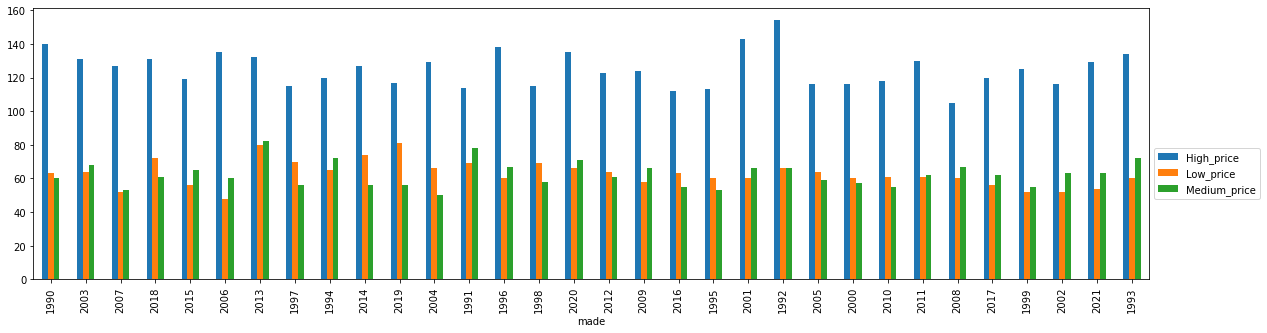

In [17]:
from matplotlib.pyplot import figure
ps.options.plotting.backend = 'matplotlib'

train_ps.pivot_table(values='made', index=['made'],columns='price_cat_name', aggfunc='count',fill_value=0).plot.bar()
plt.gcf().set_size_inches(20, 5)
plt.legend( bbox_to_anchor=(1, 0.5))


In [18]:
train_ps.groupby(["hasYard"]).median() 

,squareMeters,numberOfRooms,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cat_price
hasYard,,,,,,,,,,,,,,,,,
1,50015,51,1,50,51582,5,5,2005,0,0,4992,5026,550,0,5,5010457.9,1
0,50223,51,0,50,49748,5,5,2005,1,1,5120,5032,560,1,5,5028282.1,2


In [19]:
train_ps[['squareMeters','numberOfRooms','price']].describe() 

,squareMeters,numberOfRooms,price
count,8004.000000,8004.000000,8.004000e+03
mean,49933.997626,50.583208,4.999808e+06
std,28857.052125,28.812682,2.885693e+06
min,89.000000,1.000000,1.031350e+04
25%,25004.000000,25.000000,2.508814e+06
50%,50102.000000,51.000000,5.015730e+06
75%,74880.000000,75.000000,7.494846e+06
max,99999.000000,100.000000,1.000677e+07


<AxesSubplot:xlabel='numberOfRooms', ylabel='price'>

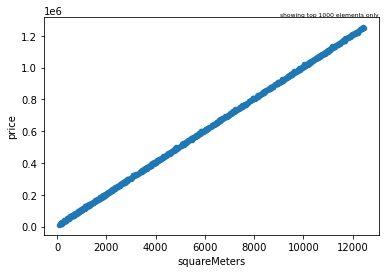

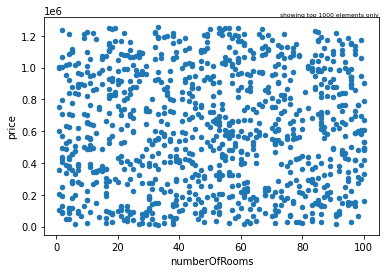

In [20]:
train_ps.plot(kind='scatter',x='squareMeters',y='price')
train_ps.plot(kind='scatter',x='numberOfRooms',y='price')

<AxesSubplot:ylabel='Frequency'>

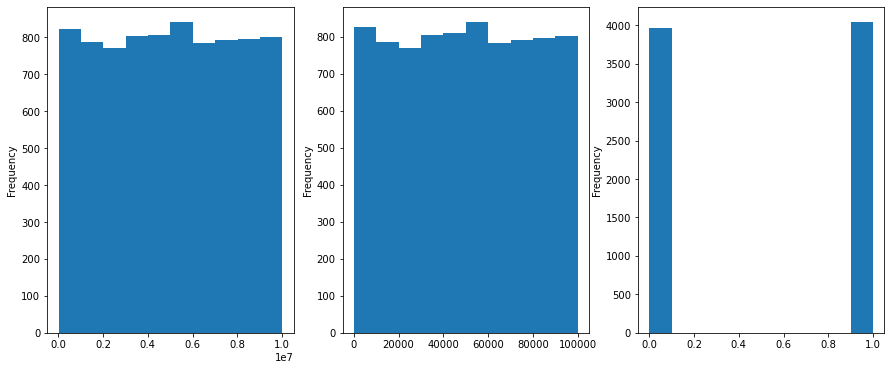

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6 ))
train_ps['price'].hist(ax=axes[0])
train_ps['squareMeters'].hist(ax=axes[1])
train_ps['hasYard'].hist(ax=axes[2])

<AxesSubplot:>

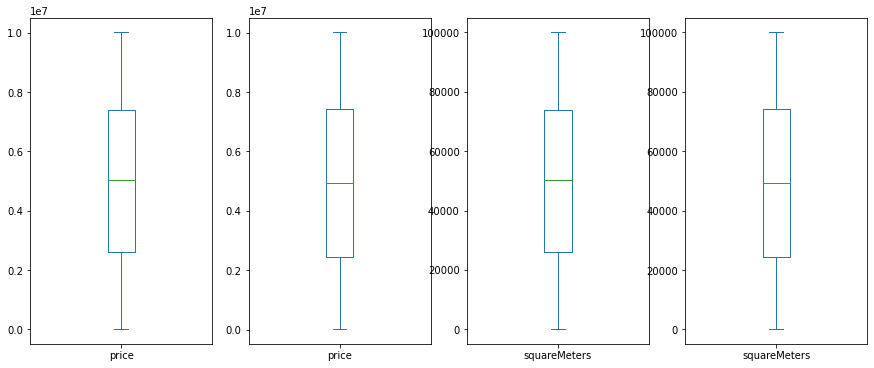

In [22]:
#train_ps['price'].plot.box(by=train_ps['hasYard'])
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(15, 6 ))
train_ps.loc[train_ps['hasYard']==0,'price'].plot.box(ax=axes[0])
train_ps.loc[train_ps['hasYard']==1,'price'].plot.box(ax=axes[1])
train_ps.loc[train_ps['hasYard']==0,'squareMeters'].plot.box(ax=axes[2])
train_ps.loc[train_ps['hasYard']==1,'squareMeters'].plot.box(ax=axes[3])


## Modeling

In [23]:
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [24]:
sqlTrans=SQLTransformer(
    statement="SELECT  squareMeters, hasYard, numberOfRooms, price as label FROM __THIS__"
)

In [25]:
assembler=VectorAssembler(inputCols=["squareMeters","hasYard","numberOfRooms"],outputCol="features",handleInvalid='keep')

In [26]:
lr= LinearRegression()

In [27]:
pipeline = Pipeline(stages= [sqlTrans, assembler, lr])

In [28]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0])\
    .addGrid(lr.fitIntercept, [False,True])\
    .addGrid(lr.elasticNetParam, [0])\
    .build()

In [29]:
assembler.transform(
    sqlTrans.transform(train)
).select("label","features").show(5)

+-------+----------------+
|  label|        features|
+-------+----------------+
|10313.5| [89.0,0.0,33.0]|
|14431.3|[111.0,0.0,32.0]|
|13229.1|[123.0,0.0,61.0]|
|15488.0|[128.0,0.0,38.0]|
|22670.7|[141.0,0.0,16.0]|
+-------+----------------+
only showing top 5 rows



In [30]:
lrmodel=lr.fit(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("features", "label")
)

In [31]:
trainingSummary=lrmodel.summary

In [32]:
print("Coefficients: " + str(lrmodel.coefficients))

Coefficients: [99.99985048013832,3121.1887825121776,2.8374788191304043]


In [33]:
print("Intercept: " + str(lrmodel.intercept))

Intercept: 4696.798150003741


In [34]:
trainingSummary=lrmodel.summary
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

+-------------------+
|          residuals|
+-------------------+
|-3376.9216437673567|
|-1456.2808755112674|
| -3940.765967027708|
| -2116.603206588403|
| 3828.5232711906683|
+-------------------+
only showing top 5 rows

RMSE: 2879.232175
r2: 0.999999


In [35]:
preds=lrmodel.transform(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label", "features")
)
     

In [36]:
preds.show(5)

+-------+----------------+------------------+
|  label|        features|        prediction|
+-------+----------------+------------------+
|10313.5| [89.0,0.0,33.0]|13690.421643767357|
|14431.3|[111.0,0.0,32.0]|15887.580875511267|
|13229.1|[123.0,0.0,61.0]| 17169.86596702771|
|15488.0|[128.0,0.0,38.0]|17604.603206588403|
|22670.7|[141.0,0.0,16.0]|18842.176728809332|
+-------+----------------+------------------+
only showing top 5 rows



In [37]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0])\
    .addGrid(lr.fitIntercept, [False,True])\
    .addGrid(lr.elasticNetParam, [0])\
    .build()

In [38]:
lr=LinearRegression()
crossval=CrossValidator(estimator = lr,
                         estimatorParamMaps=paramGrid,
                         evaluator=RegressionEvaluator(metricName='rmse'),
                         numFolds=5)      

In [39]:
cvModel=crossval.fit(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label","features")
)

In [40]:
list(zip(cvModel.avgMetrics,paramGrid))

[(2880.8422413428934,
  {Param(parent='LinearRegression_d491d10cc2c7', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_d491d10cc2c7', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LinearRegression_d491d10cc2c7', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (2880.8422413428934,
  {Param(parent='LinearRegression_d491d10cc2c7', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_d491d10cc2c7', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LinearRegression_d491d10cc2c7', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

In [41]:
print(cvModel.bestModel._java_obj.intercept(), cvModel.bestModel._java_obj.coefficients())

4696.798150003741 [99.99985048013832,3121.1887825121776,2.8374788191304043]


In [42]:
preds=cvModel.transform(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label","features")
)

In [43]:
preds.show(5)

+-------+----------------+------------------+
|  label|        features|        prediction|
+-------+----------------+------------------+
|10313.5| [89.0,0.0,33.0]|13690.421643767357|
|14431.3|[111.0,0.0,32.0]|15887.580875511267|
|13229.1|[123.0,0.0,61.0]| 17169.86596702771|
|15488.0|[128.0,0.0,38.0]|17604.603206588403|
|22670.7|[141.0,0.0,16.0]|18842.176728809332|
+-------+----------------+------------------+
only showing top 5 rows



In [44]:
RegressionEvaluator().evaluate(cvModel.transform(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label","features")
))

2879.2321752353055

### Linear  Regression with Polynomial fit.

In [394]:
from pyspark.ml.feature import PolynomialExpansion

sqlTrans=SQLTransformer(
    statement="SELECT  squareMeters, hasYard, numberOfRooms, price as label FROM __THIS__"
)



In [395]:
assembler=VectorAssembler(inputCols=["squareMeters","hasYard","numberOfRooms"],outputCol="features_mlr",handleInvalid='keep')
assembler.transform(sqlTrans.transform(train)).select("label","features_mlr").show(5)

+-------+----------------+
|  label|    features_mlr|
+-------+----------------+
|10313.5| [89.0,0.0,33.0]|
|14431.3|[111.0,0.0,32.0]|
|13229.1|[123.0,0.0,61.0]|
|15488.0|[128.0,0.0,38.0]|
|22670.7|[141.0,0.0,16.0]|
+-------+----------------+
only showing top 5 rows



In [396]:
pe=PolynomialExpansion(inputCol="features_mlr", outputCol="polyFeatures")

In [397]:
pp = Pipeline(stages=[sqlTrans,assembler,pe])
ex=pp.fit(train)

In [398]:
mlr= LinearRegression(labelCol='label',featuresCol='polyFeatures')
evaluator = RegressionEvaluator()

In [400]:
ppl_pr = Pipeline(stages = [assembler,ex,mlr])
paramGrid = ParamGridBuilder() \
      .addGrid(mlr.regParam,[0.1, 0.01, 0.001, 0.0001]) \
      .addGrid(mlr.fitIntercept, [False,True]) \
      .addGrid(mlr.elasticNetParam, [0,0.5,0.8,1])\
      .build()
crossval = CrossValidator(estimator=ppl_pr, estimatorParamMaps=paramGrid, evaluator=evaluator,numFolds= 5)
model_mlr =crossval.fit(train)



In [401]:
predictions_mlr = model_mlr.transform(test)
predictions_mlr.show(truncate=False)

+------------+-------+-------------+--------+-----------------+----------------------------------------------------------+------------------+
|squareMeters|hasYard|numberOfRooms|label   |features_mlr     |polyFeatures                                              |prediction        |
+------------+-------+-------------+--------+-----------------+----------------------------------------------------------+------------------+
|137         |0      |32           |21201.1 |[137.0,0.0,32.0] |[137.0,18769.0,0.0,0.0,0.0,32.0,4384.0,0.0,1024.0]        |18379.6896566469  |
|229         |1      |49           |27438.4 |[229.0,1.0,49.0] |[229.0,52441.0,1.0,229.0,1.0,49.0,11221.0,49.0,2401.0]    |30699.03320730316 |
|303         |0      |75           |31966.1 |[303.0,0.0,75.0] |[303.0,91809.0,0.0,0.0,0.0,75.0,22725.0,0.0,5625.0]       |35227.363103178235|
|371         |1      |29           |45524.8 |[371.0,1.0,29.0] |[371.0,137641.0,1.0,371.0,1.0,29.0,10759.0,29.0,841.0]    |44769.38587870787 |
|388  

In [405]:
from pyspark.mllib.evaluation import MulticlassMetrics

pred=predictions_mlr.select(['label', 'polyFeatures']) 
pred.show(truncate=False)

+--------+----------------------------------------------------------+
|label   |polyFeatures                                              |
+--------+----------------------------------------------------------+
|21201.1 |[137.0,18769.0,0.0,0.0,0.0,32.0,4384.0,0.0,1024.0]        |
|27438.4 |[229.0,52441.0,1.0,229.0,1.0,49.0,11221.0,49.0,2401.0]    |
|31966.1 |[303.0,91809.0,0.0,0.0,0.0,75.0,22725.0,0.0,5625.0]       |
|45524.8 |[371.0,137641.0,1.0,371.0,1.0,29.0,10759.0,29.0,841.0]    |
|44847.8 |[388.0,150544.0,1.0,388.0,1.0,11.0,4268.0,11.0,121.0]     |
|43545.0 |[389.0,151321.0,0.0,0.0,0.0,28.0,10892.0,0.0,784.0]       |
|47967.6 |[460.0,211600.0,0.0,0.0,0.0,62.0,28520.0,0.0,3844.0]      |
|52762.9 |[465.0,216225.0,1.0,465.0,1.0,54.0,25110.0,54.0,2916.0]   |
|58180.1 |[466.0,217156.0,1.0,466.0,1.0,83.0,38678.0,83.0,6889.0]   |
|62166.4 |[533.0,284089.0,1.0,533.0,1.0,84.0,44772.0,84.0,7056.0]   |
|65326.3 |[562.0,315844.0,0.0,0.0,0.0,95.0,53390.0,0.0,9025.0]      |
|66663.2 |[605.0,366

In [406]:
bestModel= model_mlr.bestModel
for x in range(len(bestModel.stages)):
    print(bestModel.stages[x])

VectorAssembler_bc1ceda1ffc7
PipelineModel_524c2d91ad1b
LinearRegressionModel: uid=LinearRegression_fb2eb9c37a9a, numFeatures=9


In [407]:
test.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|  price|cat_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+
|         137|           32|      0|      1|    47|   40384|            5|            1|2021|         0|                1|    6831| 1323|   242|             0|           9|21201.1|        0|
|         229|           49|      1|      0|     6|   72140|            2|            1|2014|         1|                0|    1820|  999|   805|             1|           4|27438.4|        0|
|         303|           75|      0|      0| 

### Random Forest Calssifier. 
### Here the data is used for a classification problem and 'cat_price'has been considered as the predicted value. We want to know that if the numeric and binary estimators have any imapct on price being in low, medium or high range. If yes , how much is the prediction accuracy. So we modify the variables in train and test data and get the model fit with predictions.

#### Here the packages are imported and price variable is removed for sanity. 

In [261]:

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
train_rf=train
train_rf=train_rf.drop('price')
test_rf=test
test_rf=test_rf.drop('price')
train_rf.na.fill(value=0).show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|cat_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|          89|           33|      0|      0|    72|   61648|            3|            4|1995|         0|                1|    3114| 1258|   264|             1|           9|        0|
|         111|           32|      0|      1|    34|   80623|            1|            4|2003|         1|                0|    2239| 2795|   951|             1|           7|        0|
|         123|           61|      0|      0|     1|   33633|            9|           

In [253]:
'''

from pyspark.sql.functions import when
train_rf = train_rf.withColumn("cat_price", when(train_rf.cat_price == 0,"Low_price") \
      .when(train_rf.cat_price == 1,"Medium_price") \
      .when(train_rf.cat_price==2,'High_price'))
train_rf.show(5)
'''

'\n\nfrom pyspark.sql.functions import when\ntrain_rf = train_rf.withColumn("cat_price", when(train_rf.cat_price == 0,"Low_price")       .when(train_rf.cat_price == 1,"Medium_price")       .when(train_rf.cat_price==2,\'High_price\'))\ntrain_rf.show(5)\n'

In [254]:
'''

from pyspark.sql.functions import when
test_rf = test_rf.withColumn("cat_price", when(test.cat_price == 0,"Low_price") \
      .when(test_rf.cat_price == 1,"Medium_price") \
      .when(test_rf.cat_price==2,'High_price'))
test_rf.show(5)
'''

'\n\nfrom pyspark.sql.functions import when\ntest_rf = test_rf.withColumn("cat_price", when(test.cat_price == 0,"Low_price")       .when(test_rf.cat_price == 1,"Medium_price")       .when(test_rf.cat_price==2,\'High_price\'))\ntest_rf.show(5)\n'

#### The predictor  values used here for Xs are used here are 'squareMeters','numberOfRooms','hasYard','numberOfRooms','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom','hasGuestRoom','made'

In [255]:
cols=['squareMeters','numberOfRooms','hasYard','numberOfRooms','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom','hasGuestRoom','made']
sqlTrans=SQLTransformer(statement="SELECT squareMeters,numberOfRooms, hasYard, hasPool,isNewBuilt,hasStormProtector,hasStorageRoom,hasGuestRoom,made,cat_price as label FROM __THIS__")


#### Getting assembler ready to combine inputs into features and output as the label

In [256]:
assembler=VectorAssembler(inputCols=cols,outputCol="features_rf",handleInvalid='keep')
assembler.transform(sqlTrans.transform(train_rf)).select("label","features_rf").show(5)

+-----+--------------------+
|label|         features_rf|
+-----+--------------------+
|    0|[89.0,33.0,0.0,33...|
|    0|[111.0,32.0,0.0,3...|
|    0|[123.0,61.0,0.0,6...|
|    0|[128.0,38.0,0.0,3...|
|    0|[141.0,16.0,0.0,1...|
+-----+--------------------+
only showing top 5 rows



#### Declaring the RandonForestClassfier function here as rf

In [257]:
#rf1 = RandomForestClassifier(labelCol = "label", featuresCol = "features_rf")
#pca = PCA(inputCol = "features_rf", outputCol = "pca_features_cv")
rf = RandomForestClassifier(labelCol = "label", featuresCol = "features_rf")


#### A pipe line has been set with sqlTrans, assembler and rf. The rf uses 2 parameters for optimization in the cross validation. Number of trees and Max Depth of the tress is used here for cross validation. And number of folds in cross validation will be 5. The output of the crossvalidation has been used for model fit.

In [258]:
ppl_cv = Pipeline(stages = [sqlTrans,assembler, rf])
paramGrid = ParamGridBuilder() \
      .addGrid(rf.numTrees, [3,5,10,15,20]) \
      .addGrid(rf.maxDepth, [2, 5, 10]) \
      .build()
crossval = CrossValidator(estimator = ppl_cv,estimatorParamMaps=paramGrid,evaluator=MulticlassClassificationEvaluator(),
                          numFolds= 5)
model =crossval.fit(train_rf)

'''
prediction=model.transform(
    assembler.transform(
        sqlTrans.transform(train_rf)
    ).select("label","pca_features_cv")
)
'''


'\nprediction=model.transform(\n    assembler.transform(\n        sqlTrans.transform(train_rf)\n    ).select("label","pca_features_cv")\n)\n'

#### Predicting price category with test data

In [259]:
predictions = model.transform(test_rf)
predictions.show()

+------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+-----+--------------------+--------------------+--------------------+----------+
|squareMeters|numberOfRooms|hasYard|hasPool|isNewBuilt|hasStormProtector|hasStorageRoom|hasGuestRoom|made|label|         features_rf|       rawPrediction|         probability|prediction|
+------------+-------------+-------+-------+----------+-----------------+--------------+------------+----+-----+--------------------+--------------------+--------------------+----------+
|         137|           32|      0|      1|         0|                1|             0|           9|2021|    0|[137.0,32.0,0.0,3...|[4.02089486927032...|[0.80417897385406...|       0.0|
|         229|           49|      1|      0|         1|                0|             1|           4|2014|    0|[229.0,49.0,1.0,4...|[3.76344590265714...|[0.75268918053142...|       0.0|
|         303|           75|      0|      0|         1|          

#### We have used 3 categories for the price. 0,1 & 2 as "Low Price","Medium Price" and "High Price" respectively. So order to evaluate its output parameters multiclass evaluator has been used with accuracy as the primary metric to obtain accuracy of the test prediction.

In [260]:

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Random Forest Classifier Accuracy:', multi_evaluator.evaluate(predictions))

Random Forest classifier Accuracy: 0.9979959919839679


In [284]:
bestModel= model.bestModel
for x in range(len(bestModel.stages)):
    print(bestModel.stages[x])

SQLTransformer_6b95ee7a518a
VectorAssembler_7c4e2ad44238
RandomForestClassificationModel: uid=RandomForestClassifier_30aa7f262a96, numTrees=5, numClasses=3, numFeatures=10


In [291]:
# Confusion Matrix
from pyspark.mllib.evaluation import MulticlassMetrics

pred=predictions.select(['label', 'features_rf']) 
pred.show()


+-----+--------------------+
|label|         features_rf|
+-----+--------------------+
|    0|[137.0,32.0,0.0,3...|
|    0|[229.0,49.0,1.0,4...|
|    0|[303.0,75.0,0.0,7...|
|    0|[371.0,29.0,1.0,2...|
|    0|[388.0,11.0,1.0,1...|
|    0|[389.0,28.0,0.0,2...|
|    0|[460.0,62.0,0.0,6...|
|    0|[465.0,54.0,1.0,5...|
|    0|[466.0,83.0,1.0,8...|
|    0|[533.0,84.0,1.0,8...|
|    0|[562.0,95.0,0.0,9...|
|    0|[605.0,12.0,1.0,1...|
|    0|[735.0,66.0,1.0,6...|
|    0|[817.0,80.0,0.0,8...|
|    0|[831.0,46.0,0.0,4...|
|    0|[838.0,30.0,1.0,3...|
|    0|[925.0,94.0,1.0,9...|
|    0|(10,[0,1,3,8,9],[...|
|    0|[1054.0,53.0,1.0,...|
|    0|[1078.0,27.0,1.0,...|
+-----+--------------------+
only showing top 20 rows

